The <a href="https://www.kaggle.com/c/titanic/"> Titanic challenge</a>  hosted by Kaggle is a competition in which the goal is to predict the survival or the death of a given passenger based on a set of variables describing him such as his age, his sex, or his passenger class on the boat.

I have been playing with the Titanic dataset for a while, and I have recently achieved an accuracy score of 0.8134 on the public leaderboard. As I'm writing this post, I am ranked among the top 4% of all Kagglers. 

This post is the opportunity to share my solution with you.

To make this tutorial more "academic" so that anyone could benefit, I will first start with an exploratory data analysis (EDA) then I'll follow with feature engineering and finally present the predictive model I set up.

Throughout this jupyter notebook, I will be using Python at each level of the pipeline.

The main libraries involved in this tutorial are: 

* <b>Pandas</b> for data manipulation and ingestion
* <b>Matplotlib</b> and <b> seaborn</b> for data visualization
* <b>Numpy</b> for multidimensional array computing
* <b>sklearn</b> for machine learning and predictive modeling

### Installation procedure 

A very easy way to install these packages is to download and install the <a href="http://conda.pydata.org/docs/install/quick.html#os-x-miniconda-install">Conda</a> distribution that encapsulates them all. This distribution is available on all platforms (Windows, Linux and Mac OSX).

### Nota Bene

This is my first attempt as a blogger and as a machine learning practitioner. 

If you have a question about the code or the hypotheses I made, do not hesitate to post a comment in the comment section below.

If you also have a suggestion on how this notebook could be improved, please reach out to me.

This tutorial is available on my <a href="https://github.com/ahmedbesbes/How-to-score-0.8134-in-Titanic-Kaggle-Challenge"> github </a> account.

Hope you've got everything set on your computer. Let's get started.

# I -  Exploratory data analysis

As in different data projects, we'll first start diving into the data and build up our first intuitions.

In this section, we'll be doing four things. 

- Data extraction : we'll load the dataset and have a first look at it. 
- Cleaning : we'll fill in missing values.
- Plotting : we'll create some interesting charts that'll (hopefully) spot correlations and hidden insights out of the data.
- Assumptions : we'll formulate hypotheses from the charts.

We tweak the style of this notebook a little bit to have centered plots.

In [0]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");

We import the useful libraries.

In [0]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
pd.options.display.max_columns = 100

from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns

import pylab as plot
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plot.rcParams.update(params)

In [314]:
!pwd

/content


Two datasets are available: a training set and a test set.
We'll be using the training set to build our predictive model and the testing set to score it and generate an output file to submit on the Kaggle evaluation system.

We'll see how this procedure is done at the end of this post.

Now let's start by loading the training set.

In [0]:
data = pd.read_csv('./data/train.csv')

In [316]:
print(data.shape) 

(891, 12)


We have:

- 891 rows
- 12 columns

Pandas allows you to have a sneak peak at your data.

In [317]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The Survived column is the ** target variable**. If Suvival = 1 the passenger survived, otherwise he's dead. The is the variable we're going to predict.

The other variables describe the passengers. They are the **features**.

- PassengerId: and id given to each traveler on the boat
- Pclass: the passenger class. It has three possible values: 1,2,3 (first, second and third class)
- The Name of the passeger
- The Sex
- The Age
- SibSp: number of siblings and spouses traveling with the passenger 
- Parch: number of parents and children traveling with the passenger
- The ticket number
- The ticket Fare
- The cabin number 
- The embarkation. This describe three possible areas of the Titanic from which the people embark. Three possible values S,C,Q

Pandas allows you to a have a high-level simple statistical description of the numerical features.
This can be done using the describe method.

In [318]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


The count variable shows that 177 values are missing in the Age column.

One solution is to fill in the null values with the median age. We could also impute with the mean age but the median is more robust to outliers.

In [0]:
data['Age'] = data['Age'].fillna(data['Age'].median())

Let's check the result.

In [319]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Perfect.

Let's now make some charts.

Let's visualize survival based on the gender.

In [0]:
data['Died'] = 1 - data['Survived']

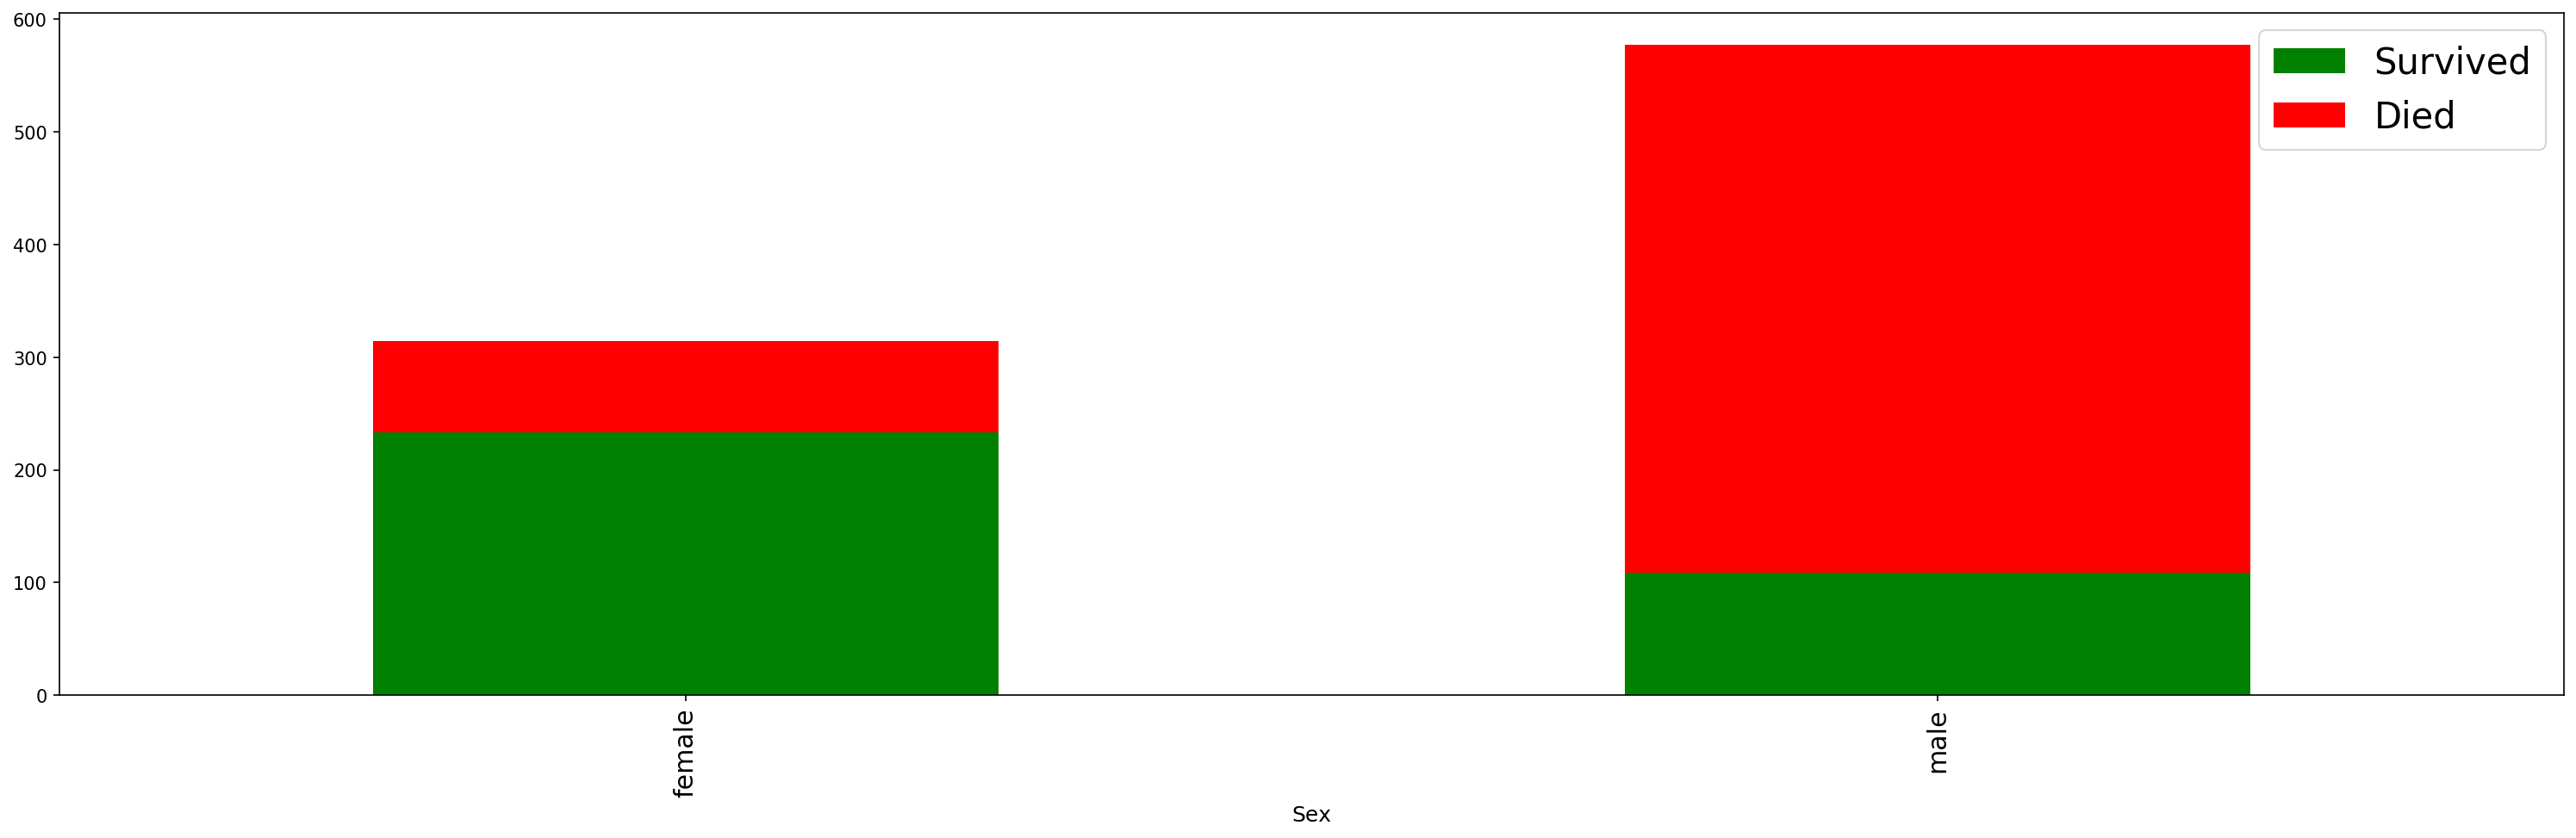

In [321]:
data.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7),
                                                          stacked=True, colors=['g', 'r']);

![energy](https://github.com/HisakaKoji/How-to-score-0.8134-in-Titanic-Kaggle-Challenge/blob/master/images/article_1/1.png?raw=1)

It looks like male passengers are more likely to succumb.

Let's plot the same graph but with ratio instead.

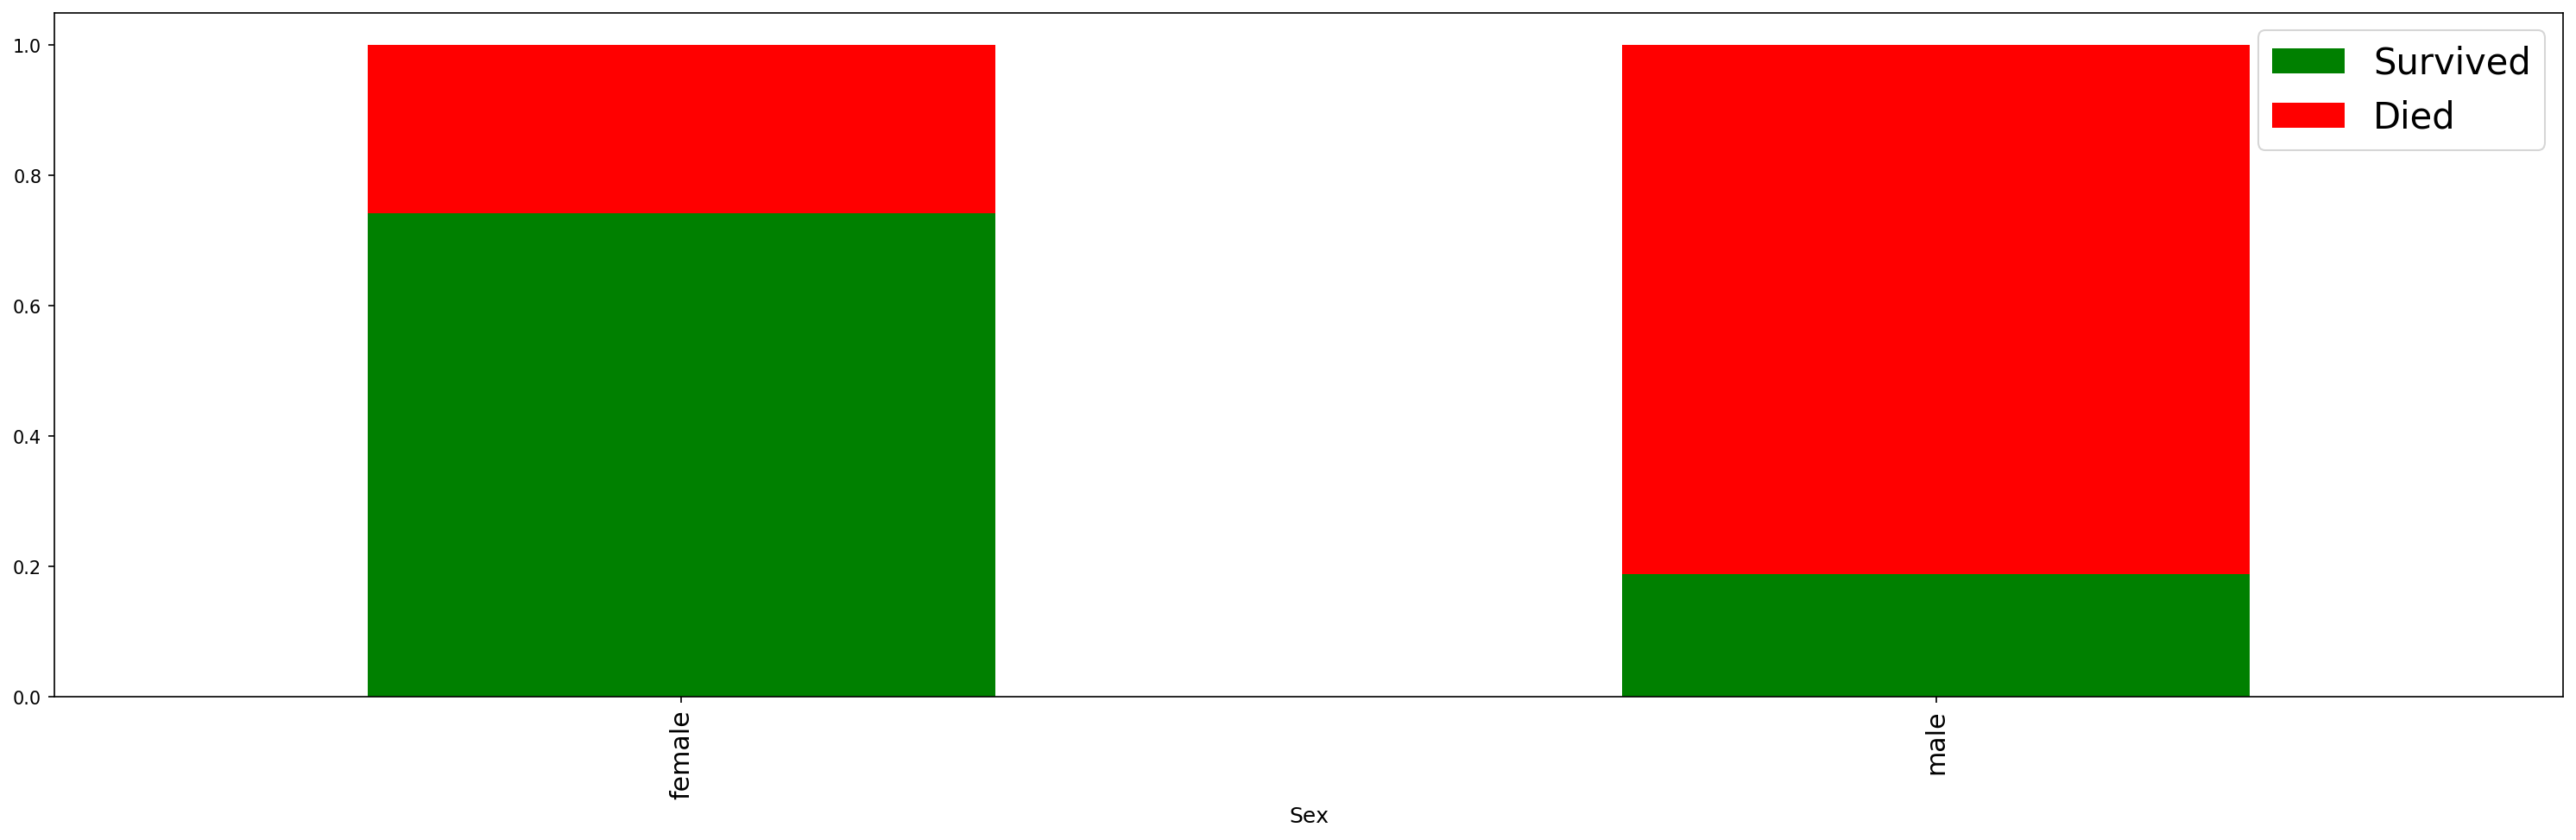

In [322]:
data.groupby('Sex').agg('mean')[['Survived', 'Died']].plot(kind='bar', figsize=(25, 7), 
                                                           stacked=True, colors=['g', 'r']);

![energy](https://github.com/HisakaKoji/How-to-score-0.8134-in-Titanic-Kaggle-Challenge/blob/master/images/article_1/2.png?raw=1)

The Sex variable seems to be a discriminative feature. Women are more likely to survive.

Let's now correlate the survival with the age variable.

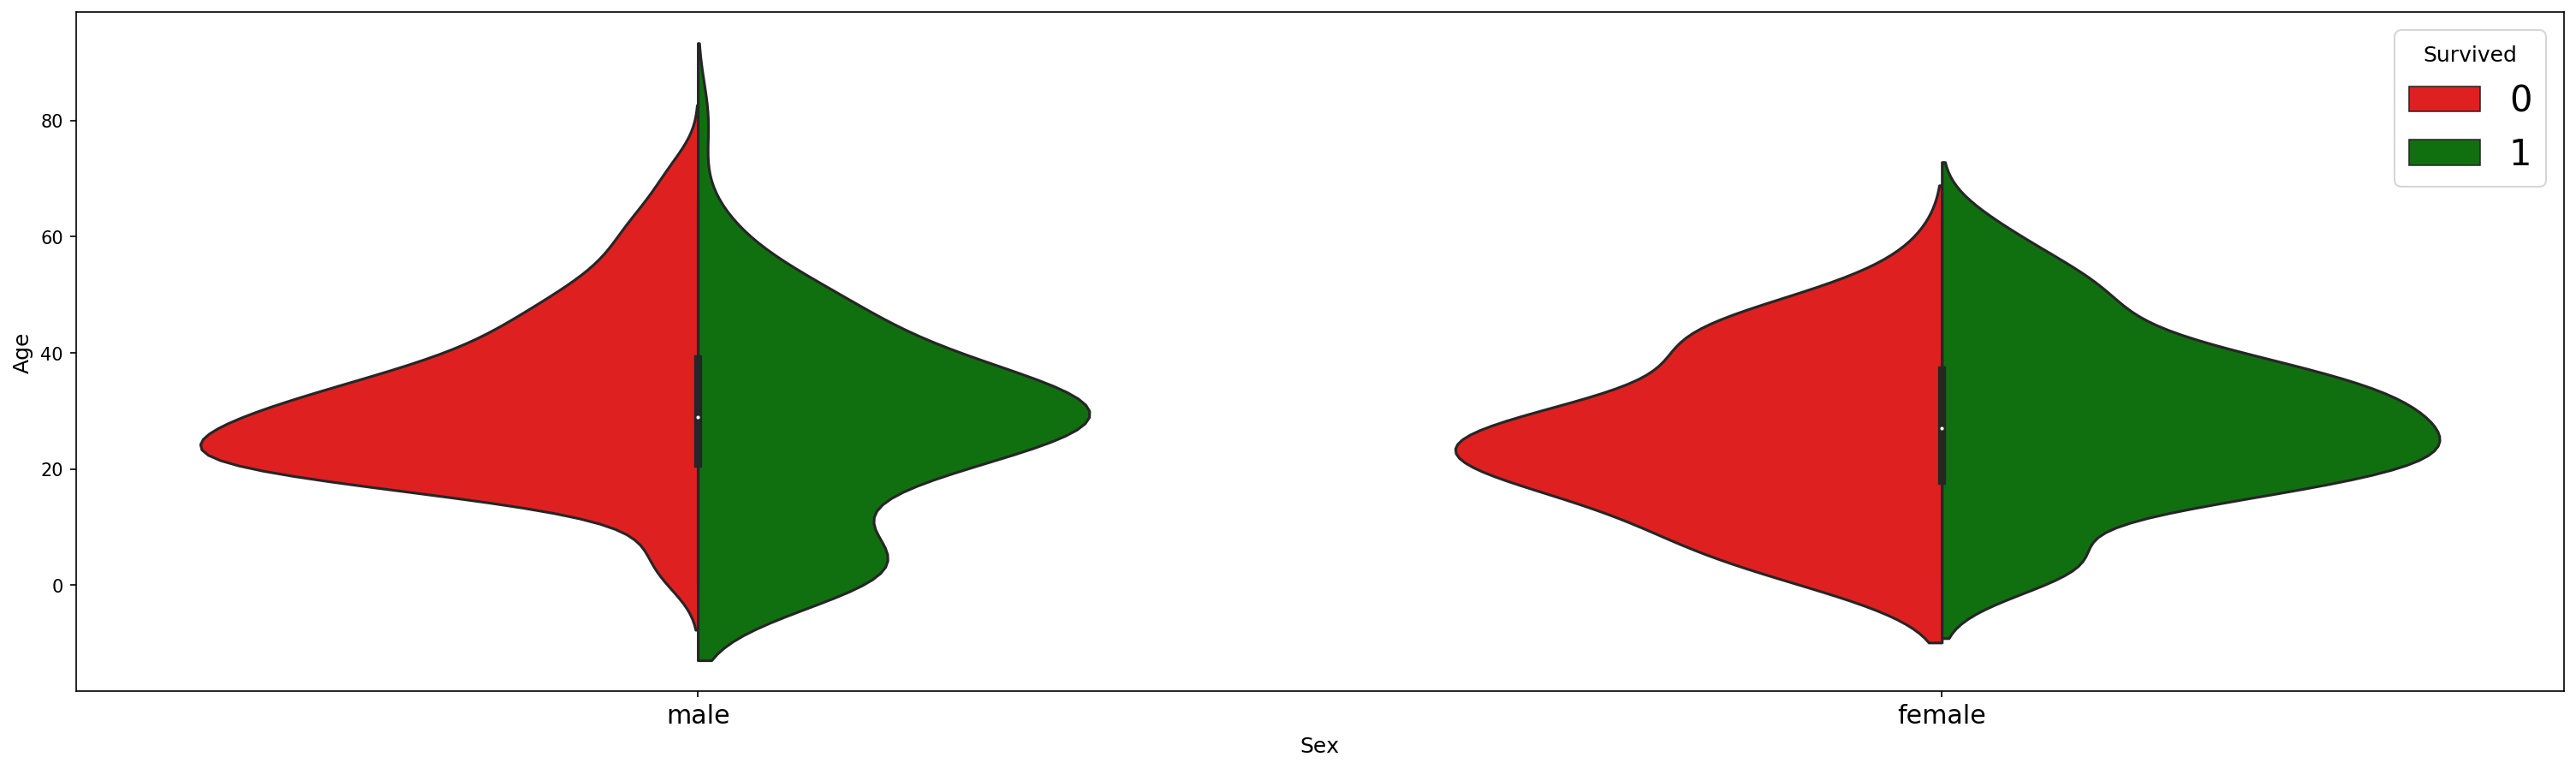

In [323]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=data, 
               split=True,
               palette={0: "r", 1: "g"}
              );

![energy](https://github.com/HisakaKoji/How-to-score-0.8134-in-Titanic-Kaggle-Challenge/blob/master/images/article_1/3.png?raw=1)

As we saw in the chart above and validate by the following:

- Women survive more than men, as depicted by the larger female green histogram 

Now, we see that:
- The age conditions the survival for male passengers:
    - Younger male tend to survive
    - A large number of passengers between 20 and 40 succumb
    
- The age doesn't seem to have a direct impact on the female survival

These violin plots confirm that one old code of conduct that sailors and captains follow in case of threatening situations: <b>"Women and children first !"</b>.

![energy](https://github.com/HisakaKoji/How-to-score-0.8134-in-Titanic-Kaggle-Challenge/blob/master/images/article_1/titanic.jpg?raw=1)

Right?

Let's now focus on the Fare ticket of each passenger and see how it could impact the survival. 

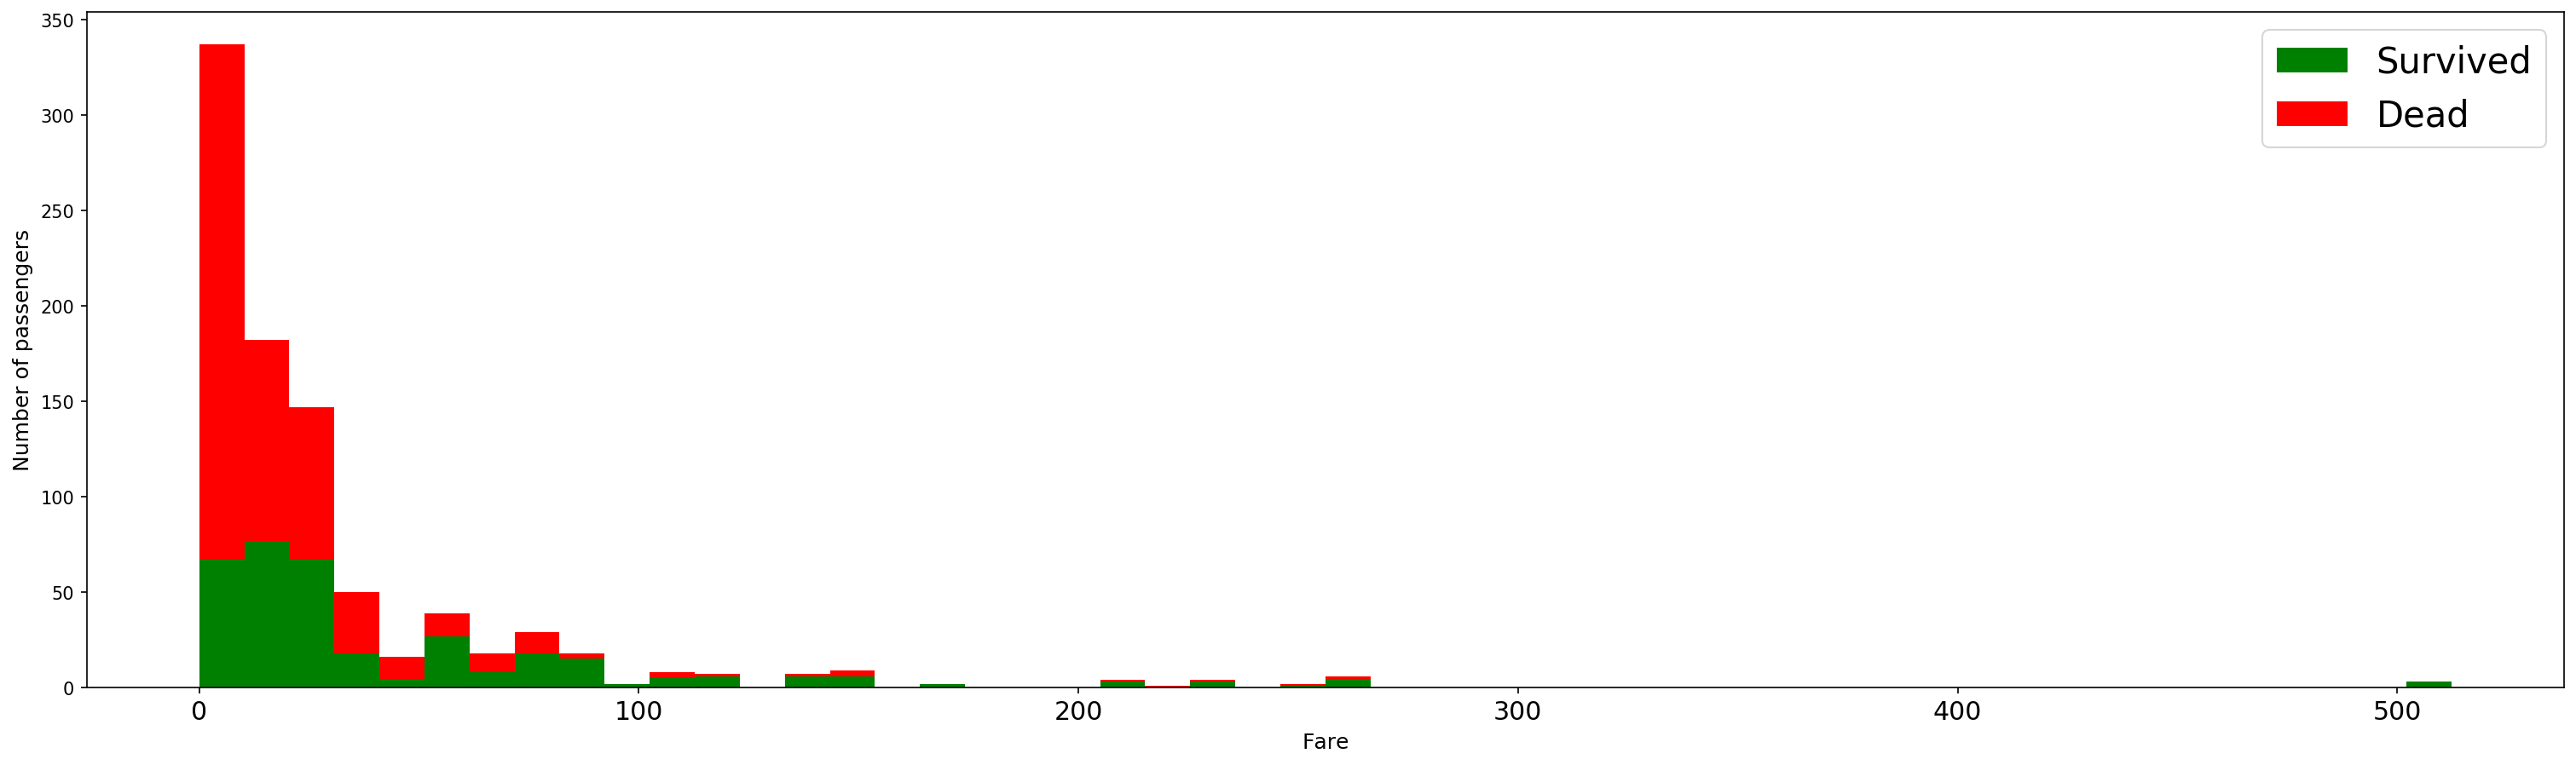

In [324]:
figure = plt.figure(figsize=(25, 7))
plt.hist([data[data['Survived'] == 1]['Fare'], data[data['Survived'] == 0]['Fare']], 
         stacked=True, color = ['g','r'],
         bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend();

![energy](https://github.com/HisakaKoji/How-to-score-0.8134-in-Titanic-Kaggle-Challenge/blob/master/images/article_1/4.png?raw=1)

Passengers with cheaper ticket fares are more likely to die. 
Put differently, passengers with more expensive tickets, and therefore a more important social status, seem to be rescued first.

Ok this is nice. Let's now combine the age, the fare and the survival on a single chart.

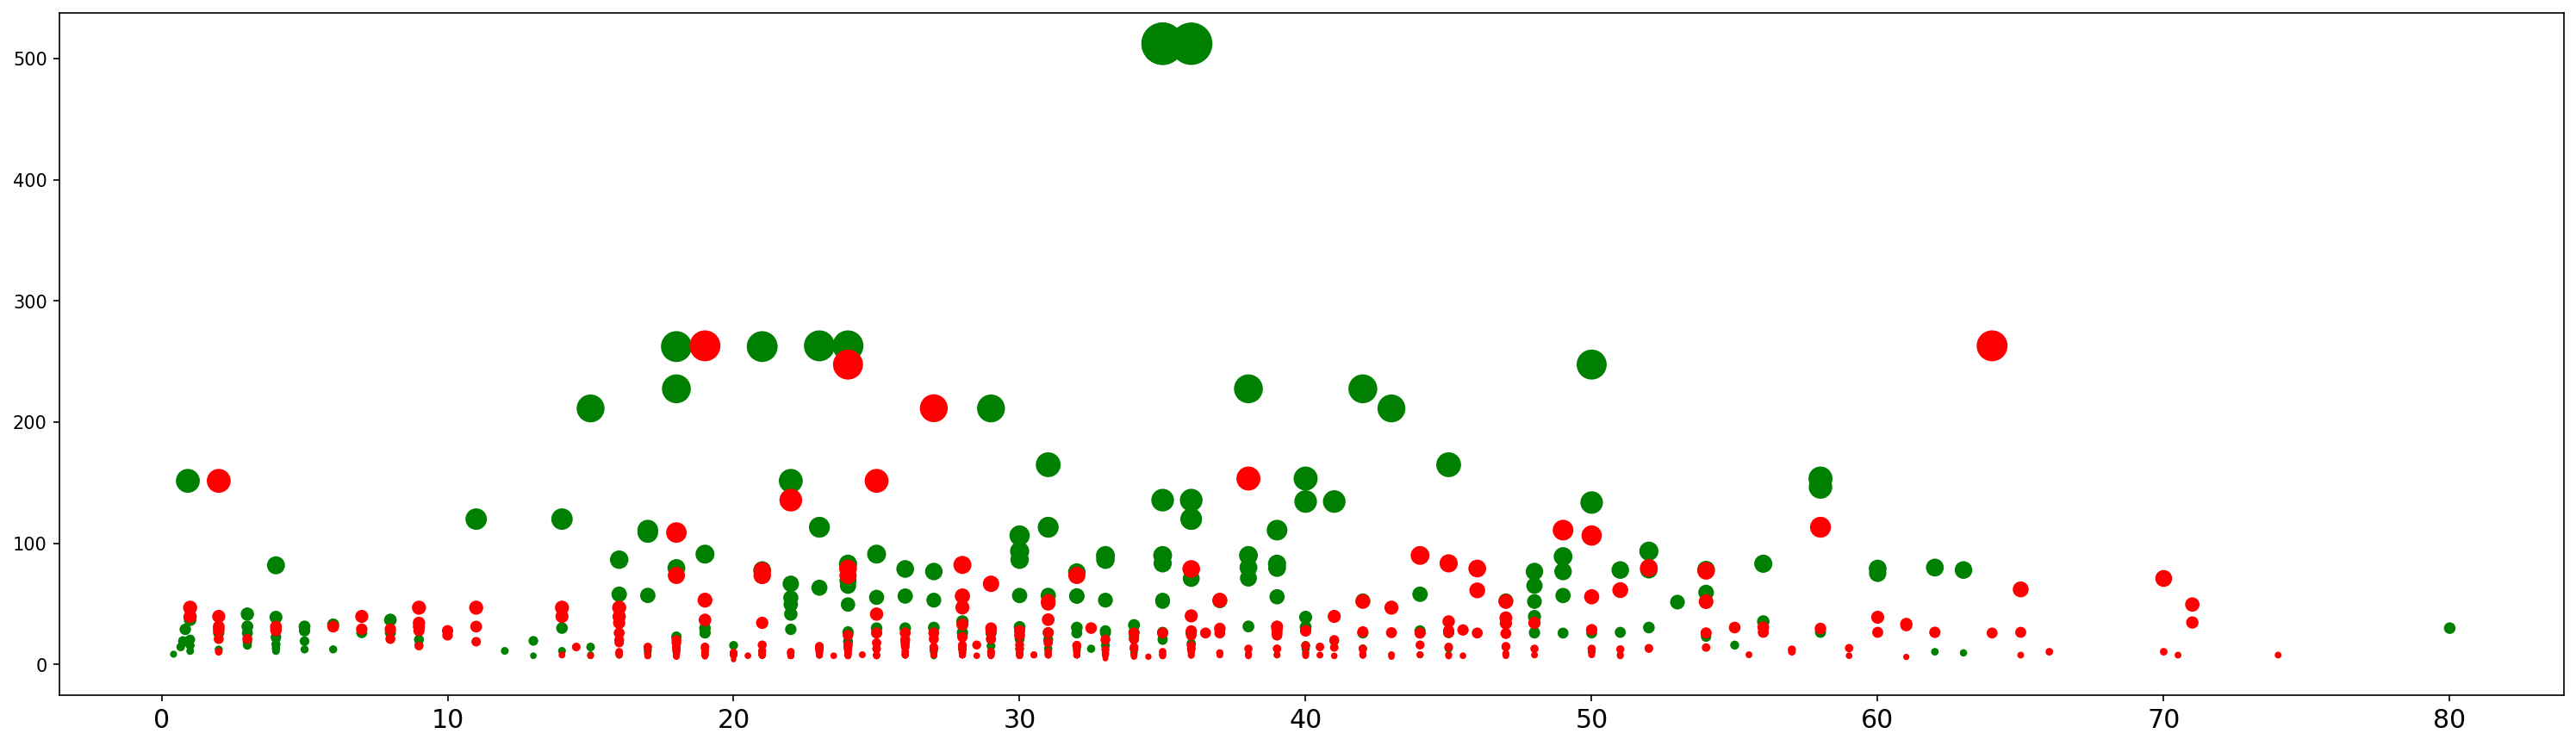

In [325]:
plt.figure(figsize=(25, 7))
ax = plt.subplot()

ax.scatter(data[data['Survived'] == 1]['Age'], data[data['Survived'] == 1]['Fare'], 
           c='green', s=data[data['Survived'] == 1]['Fare'])
ax.scatter(data[data['Survived'] == 0]['Age'], data[data['Survived'] == 0]['Fare'], 
           c='red', s=data[data['Survived'] == 0]['Fare']);

![energy](https://github.com/HisakaKoji/How-to-score-0.8134-in-Titanic-Kaggle-Challenge/blob/master/images/article_1/5.png?raw=1)

The size of the circles is proportional to the ticket fare.

On the x-axis, we have the ages and the y-axis, we consider the ticket fare.

We can observe different clusters:

1. Large green dots between x=20 and x=45: adults with the largest ticket fares
2. Small red dots between x=10 and x=45, adults from lower classes on the boat
3. Small greed dots between x=0 and x=7: these are the children that were saved

As a matter of fact, the ticket fare correlates with the class as we see it in the chart below. 

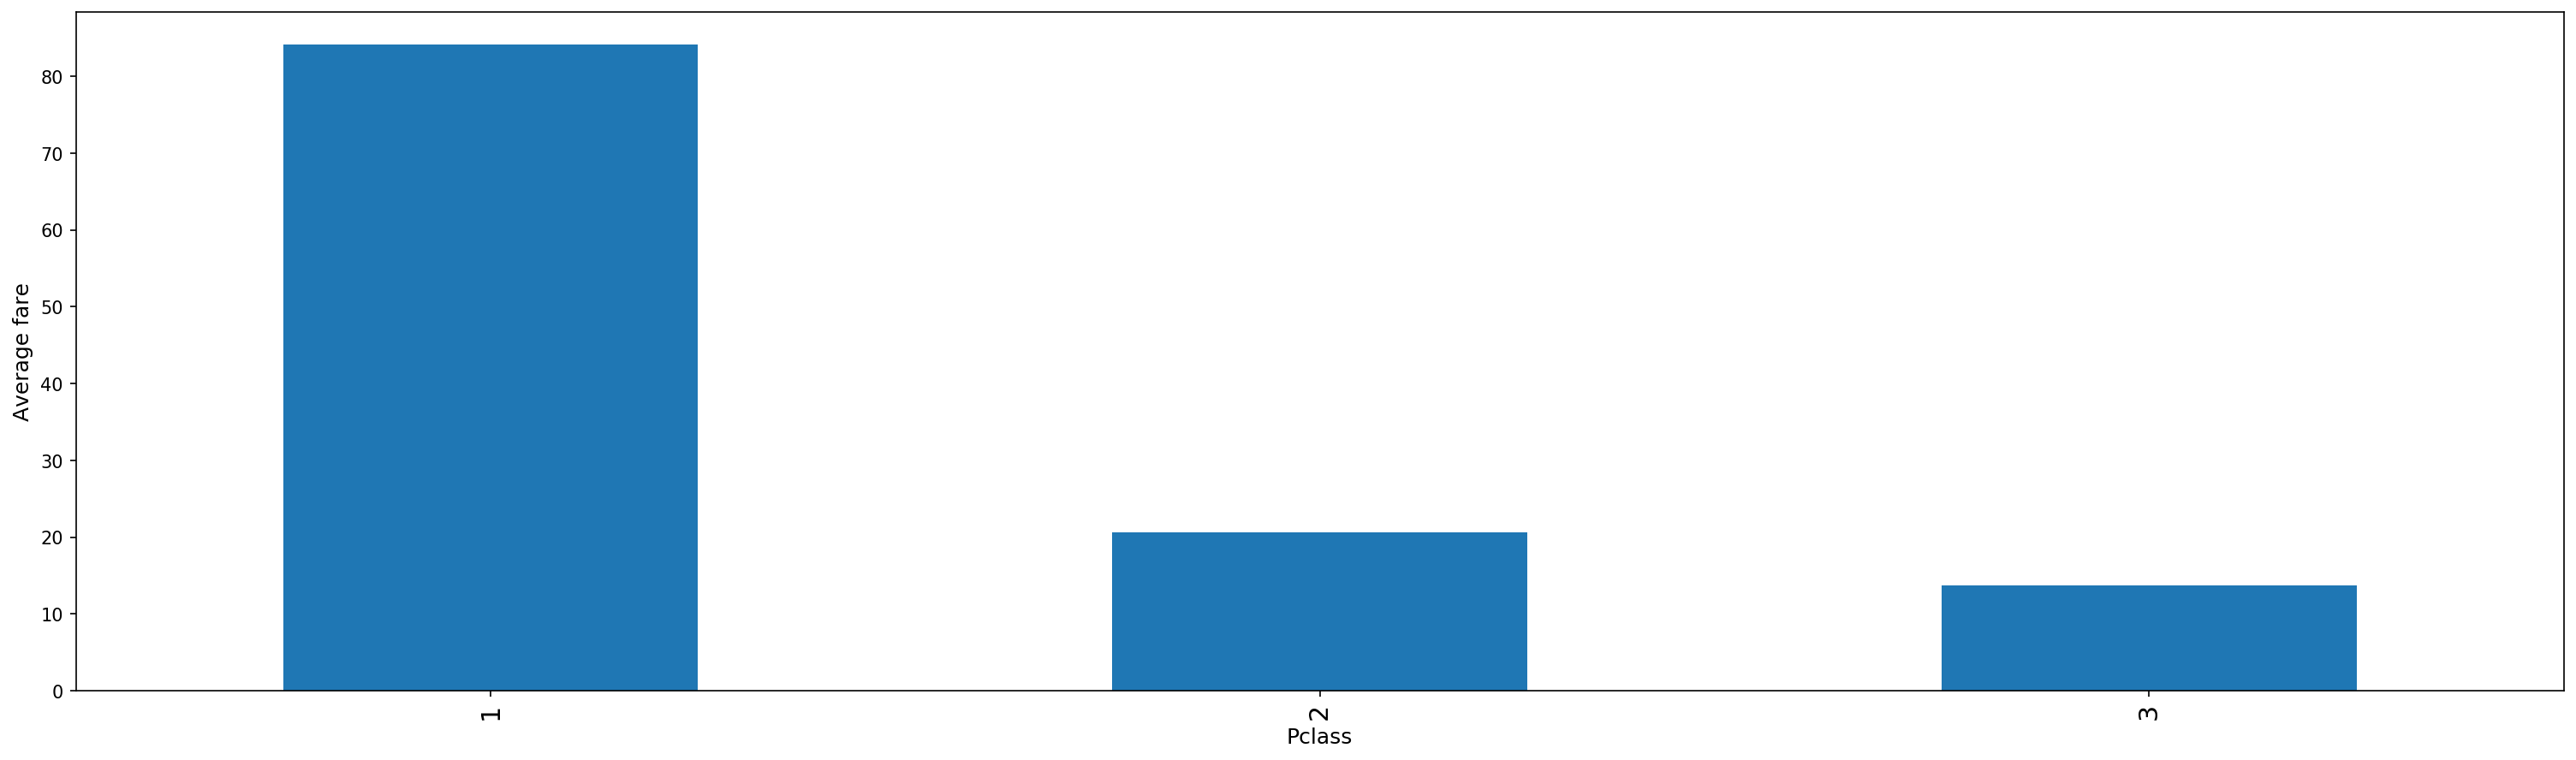

In [326]:
ax = plt.subplot()
ax.set_ylabel('Average fare')
data.groupby('Pclass').mean()['Fare'].plot(kind='bar', figsize=(25, 7), ax = ax);

![energy](https://github.com/HisakaKoji/How-to-score-0.8134-in-Titanic-Kaggle-Challenge/blob/master/images/article_1/6.png?raw=1)

Let's now see how the embarkation site affects the survival.

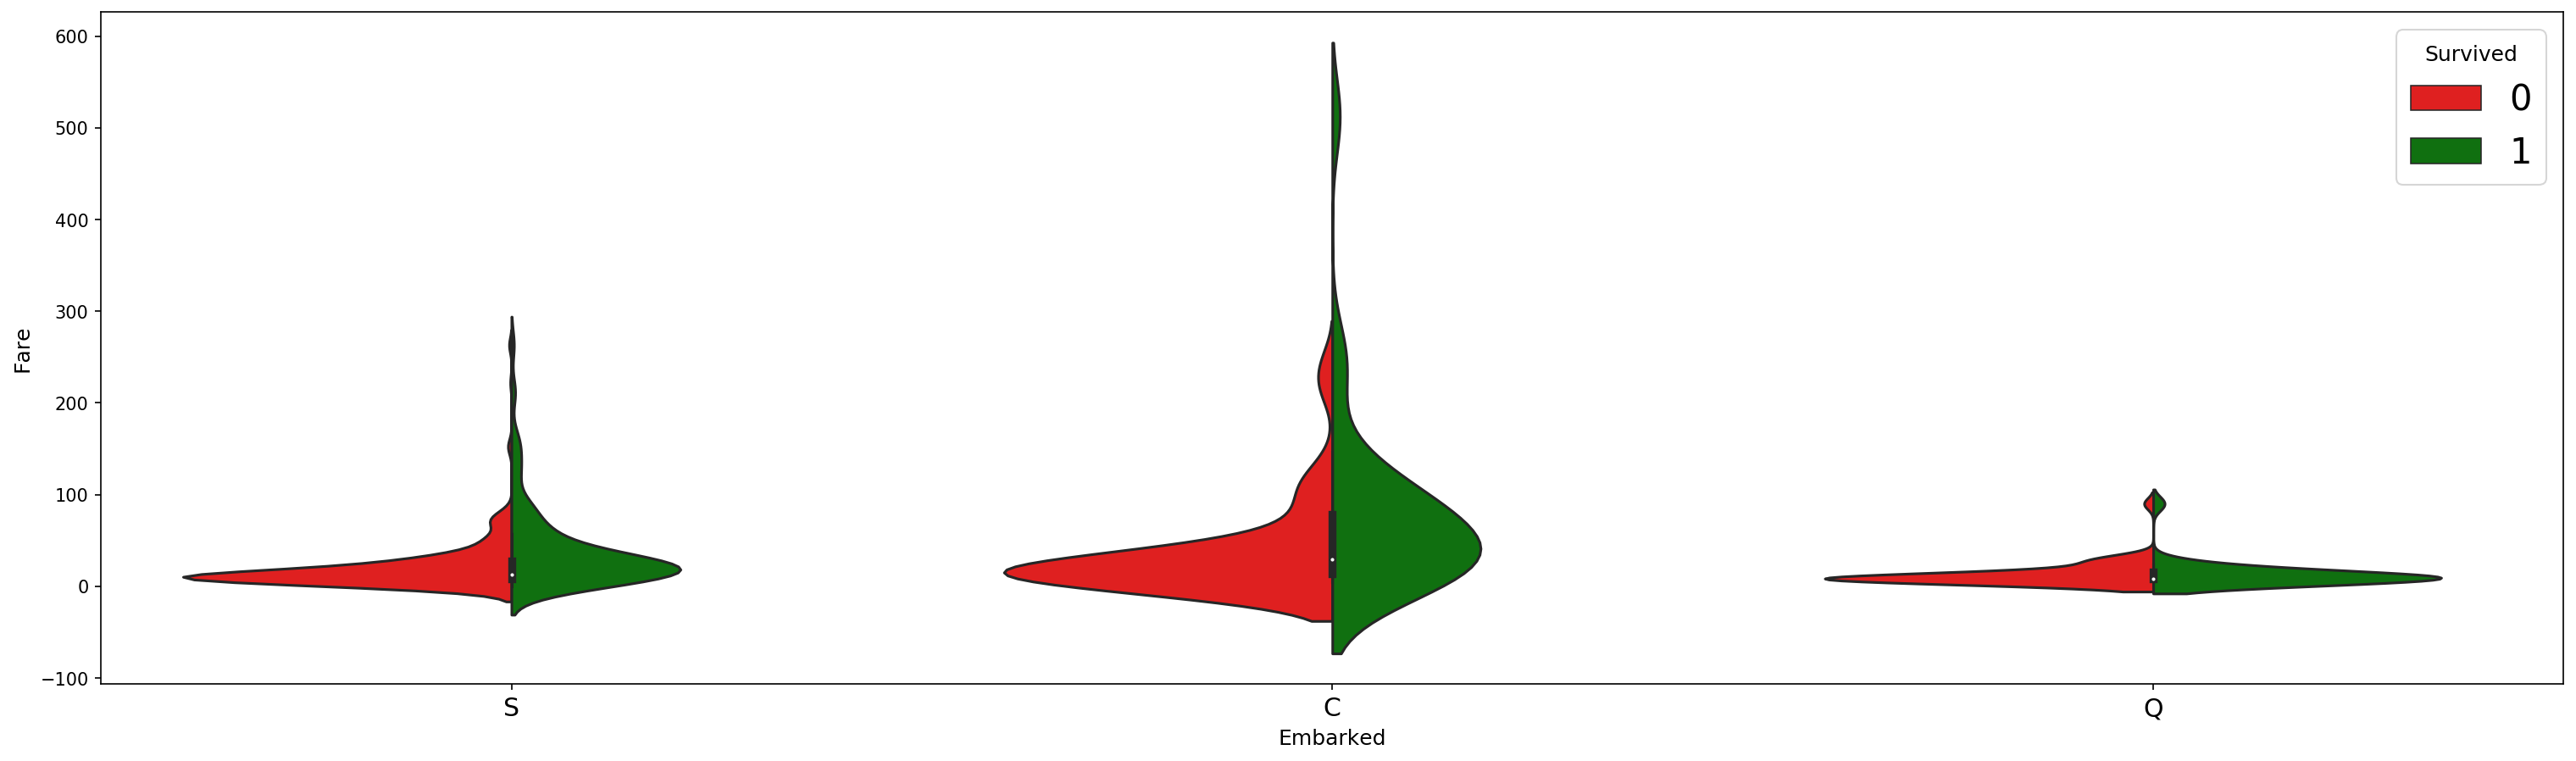

In [327]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Embarked', y='Fare', hue='Survived', data=data, split=True, palette={0: "r", 1: "g"});

![energy](https://github.com/HisakaKoji/How-to-score-0.8134-in-Titanic-Kaggle-Challenge/blob/master/images/article_1/7.png?raw=1)

It seems that the embarkation C have a wider range of fare tickets and therefore the passengers who pay the highest prices are those who survive.

We also see this happening in embarkation S and less in embarkation Q.

Let's now stop with data exploration and switch to the next part.

# II - Feature engineering

In the previous part, we flirted with the data and spotted some interesting correlations.

In this part, we'll see how to process and transform these variables in such a way the data becomes manageable by a machine learning algorithm.

We'll also create, or "engineer" additional features that will be useful in building the model.

We'll see along the way how to process text variables like the passenger names and integrate this information in our model.

We will break our code in separate functions for more clarity.

But first, let's define a print function that asserts whether or not a feature has been processed. 

In [0]:
def status(feature):
    print ('Processing', feature, ': ok')

###  Loading the data

One trick when starting a machine learning problem is to append the training set to the test set together.

We'll engineer new features using the train set to prevent information leakage. Then we'll add these variables to the test set.

Let's load the train and test sets and append them together.

In [0]:
def get_combined_data():
    # reading train data
    train = pd.read_csv('./data/train.csv')
    
    # reading test data
    test = pd.read_csv('./data/test.csv')

    # extracting and then removing the targets from the training data 
    targets = train.Survived
    train.drop(['Survived'], 1, inplace=True)
    

    # merging train data and test data for future feature engineering
    # we'll also remove the PassengerID since this is not an informative feature
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'PassengerId'], inplace=True, axis=1)
    
    return combined

In [0]:
combined = get_combined_data()

Let's have a look at the shape :

In [332]:
print(combined.shape)

(1309, 10)


train and test sets are combined.

You may notice that the total number of rows (1309) is the exact summation of the number of rows in the train set and the test set.

In [333]:
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Extracting the passenger titles

When looking at the passenger names one could wonder how to process them to extract a useful information.

If you look closely at these first examples: 

- Braund, <b> Mr.</b> Owen Harris	
- Heikkinen, <b>Miss.</b> Laina
- Oliva y Ocana, <b>Dona.</b> Fermina
- Peter, <b>Master.</b> Michael J

You will notice that each name has a title in it ! This can be a simple Miss. or Mrs. but it can be sometimes something more sophisticated like Master, Sir or Dona. In that case, we might introduce an additional information about the social status by simply parsing the name and extracting the title and converting to a binary variable.

Let's see how we'll do that in the function below.

Let's first see what the different titles are in the train set 

In [0]:
titles = set()
for name in data['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

In [335]:
print(titles)

{'Lady', 'Rev', 'Miss', 'Mme', 'Mr', 'Major', 'Mlle', 'Mrs', 'Ms', 'Capt', 'Jonkheer', 'Col', 'the Countess', 'Sir', 'Master', 'Don', 'Dr'}


In [0]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

def get_titles():
    # we extract the title from each name
    combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    combined['Title'] = combined.Title.map(Title_Dictionary)
    status('Title')
    return combined

This function parses the names and extract the titles. Then, it maps the titles to categories of titles. 
We selected : 

- Officer
- Royalty 
- Mr
- Mrs
- Miss
- Master

Let's run it !

In [337]:
combined = get_titles()

Processing Title : ok


In [338]:
combined.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


Let's check if the titles have been filled correctly.

In [339]:
combined[combined['Title'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1305,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C,NaN


There is indeed a NaN value in the line 1305. In fact the corresponding name is Oliva y Ocana, **Dona**. Fermina.

This title was not encoutered in the train dataset.

Perfect. Now we have an additional column called <b>Title</b> that contains the information.

### Processing the ages

We have seen in the first part that the Age variable was missing 177 values. This is a large number ( ~ 13% of the dataset). Simply replacing them with the mean or the median age might not be the best solution since the age may differ by groups and categories of passengers. 

To understand why, let's group our dataset by sex, Title and passenger class and for each subset compute the median age.

To avoid data leakage from the test set, we fill in missing ages in the train using the train set and we fill in ages in the test set using values calculated from the train set as well.

Number of missing ages in train set

In [340]:
print (combined.iloc[:891].Age.isnull().sum())

177


Number of missing ages in test set

In [341]:
print (combined.iloc[891:].Age.isnull().sum())

86


In [0]:
grouped_train = combined.iloc[:891].groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

In [343]:
grouped_median_train.head()

,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0


This dataframe will help us impute missing age values based on different criteria.

Look at the median age column and see how this value can be different based on the Sex, Pclass and Title put together.

For example: 

- If the passenger is female, from Pclass 1, and from royalty the median age is 40.5.
- If the passenger is male, from Pclass 3, with a Mr title, the median age is 26.

Let's create a function that fills in the missing age in <b>combined</b> based on these different attributes.

In [0]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]


def process_age():
    global combined
    # a function that fills the missing values of the Age variable
    combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    status('age')
    return combined

In [345]:
combined = process_age()

Processing age : ok


Perfect. The missing ages have been replaced. 

However, we notice a missing value in Fare, two missing values in Embarked and a lot of missing values in Cabin. We'll come back to these variables later.

Let's now process the names.

In [0]:
def process_names():
    global combined
    # we clean the Name variable
    combined.drop('Name', axis=1, inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
    combined = pd.concat([combined, titles_dummies], axis=1)
    
    # removing the title variable
    combined.drop('Title', axis=1, inplace=True)
    
    status('names')
    return combined

This function drops the Name column since we won't be using it anymore because we created a Title column.

Then we encode the title values using a dummy encoding.

You can learn about dummy coding and how to easily do it in Pandas <a href="http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html">here</a>.


In [347]:
combined = process_names()

Processing names : ok


In [348]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,1,0,0,0
1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,0,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,1,0,0,0,0
3,1,female,35.0,1,0,113803,53.1000,C123,S,0,0,0,1,0,0
4,3,male,35.0,0,0,373450,8.0500,NaN,S,0,0,1,0,0,0


As you can see : 
- there is no longer a name feature. 
- new variables (Title_X) appeared. These features are binary. 
    - For example, If Title_Mr = 1, the corresponding Title is Mr.

### Processing Fare

Let's imputed the missing fare value by the average fare computed on the train set

In [0]:
def process_fares():
    global combined
    # there's one missing fare value - replacing it with the mean.
    combined.Fare.fillna(combined.iloc[:891].Fare.mean(), inplace=True)
    status('fare')
    return combined

This function simply replaces one missing Fare value by the mean.

In [350]:
combined = process_fares()

Processing fare : ok


### Processing Embarked

In [0]:
def process_embarked():
    global combined
    # two missing embarked values - filling them with the most frequent one in the train  set(S)
    combined.Embarked.fillna('S', inplace=True)
    # dummy encoding 
    embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
    combined = pd.concat([combined, embarked_dummies], axis=1)
    combined.drop('Embarked', axis=1, inplace=True)
    status('embarked')
    return combined

This functions replaces the two missing values of Embarked with the most frequent Embarked value.

In [352]:
combined = process_embarked()

Processing embarked : ok


In [353]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S
0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,0,0,1,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,C85,0,0,0,1,0,0,1,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,C123,0,0,0,1,0,0,0,0,1
4,3,male,35.0,0,0,373450,8.0500,NaN,0,0,1,0,0,0,0,0,1


### Processing Cabin

In [0]:
train_cabin, test_cabin = set(), set()

for c in combined.iloc[:891]['Cabin']:
    try:
        train_cabin.add(c[0])
    except:
        train_cabin.add('U')
        
for c in combined.iloc[891:]['Cabin']:
    try:
        test_cabin.add(c[0])
    except:
        test_cabin.add('U')

In [355]:
print(train_cabin)

{'G', 'U', 'D', 'A', 'F', 'B', 'E', 'T', 'C'}


In [356]:
print (test_cabin)

{'G', 'U', 'D', 'A', 'F', 'B', 'E', 'C'}


We don't have any cabin letter in the test set that is not present in the train set.

In [0]:
def process_cabin():
    global combined    
    # replacing missing cabins with U (for Uknown)
    combined.Cabin.fillna('U', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')    
    combined = pd.concat([combined, cabin_dummies], axis=1)

    combined.drop('Cabin', axis=1, inplace=True)
    status('cabin')
    return combined

This function replaces NaN values with U (for <i>Unknow</i>). It then maps each Cabin value to the first letter.
Then it encodes the cabin values using dummy encoding again.

In [358]:
combined = process_cabin()

Processing cabin : ok


Ok no missing values now.

In [359]:
combined.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,male,22.0,1,0,A/5 21171,7.2500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,1,female,38.0,1,0,PC 17599,71.2833,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,female,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,female,35.0,1,0,113803,53.1000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,3,male,35.0,0,0,373450,8.0500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1


### Processing Sex

In [0]:
def process_sex():
    global combined
    # mapping string values to numerical one 
    combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})
    status('Sex')
    return combined

This function maps the string values male and female to 1 and 0 respectively. 

In [361]:
combined = process_sex()

Processing Sex : ok


### Processing Pclass

In [0]:
def process_pclass():
    
    global combined
    # encoding into 3 categories:
    pclass_dummies = pd.get_dummies(combined['Pclass'], prefix="Pclass")
    
    # adding dummy variable
    combined = pd.concat([combined, pclass_dummies],axis=1)
    
    # removing "Pclass"
    combined.drop('Pclass',axis=1,inplace=True)
    
    status('Pclass')
    return combined

This function encodes the values of Pclass (1,2,3) using a dummy encoding.

In [364]:
combined = process_pclass()

Processing Pclass : ok


### Processing Ticket

Let's first see how the different ticket prefixes we have in our dataset

In [0]:
def cleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))

    if len(ticket) > 0:
        print(ticket[0])
        return ticket[0]
    else: 
        print('XXX')
        return 'XXX'

In [366]:
tickets = set()
for t in combined['Ticket']:
    print(t)
    tickets.add(cleanTicket(t))

A/5 21171
A5
PC 17599
PC
STON/O2. 3101282
STONO2
113803
XXX
373450
XXX
330877
XXX
17463
XXX
349909
XXX
347742
XXX
237736
XXX
PP 9549
PP
113783
XXX
A/5. 2151
A5
347082
XXX
350406
XXX
248706
XXX
382652
XXX
244373
XXX
345763
XXX
2649
XXX
239865
XXX
248698
XXX
330923
XXX
113788
XXX
349909
XXX
347077
XXX
2631
XXX
19950
XXX
330959
XXX
349216
XXX
PC 17601
PC
PC 17569
PC
335677
XXX
C.A. 24579
CA
PC 17604
PC
113789
XXX
2677
XXX
A./5. 2152
A5
345764
XXX
2651
XXX
7546
XXX
11668
XXX
349253
XXX
SC/Paris 2123
SCParis
330958
XXX
S.C./A.4. 23567
SCA4
370371
XXX
14311
XXX
2662
XXX
349237
XXX
3101295
XXX
A/4. 39886
A4
PC 17572
PC
2926
XXX
113509
XXX
19947
XXX
C.A. 31026
CA
2697
XXX
C.A. 34651
CA
CA 2144
CA
2669
XXX
113572
XXX
36973
XXX
347088
XXX
PC 17605
PC
2661
XXX
C.A. 29395
CA
S.P. 3464
SP
3101281
XXX
315151
XXX
C.A. 33111
CA
CA 2144
CA
S.O.C. 14879
SOC
2680
XXX
1601
XXX
348123
XXX
349208
XXX
374746
XXX
248738
XXX
364516
XXX
345767
XXX
345779
XXX
330932
XXX
113059
XXX
SO/C 14885
SOC
3101278
XXX
W./C

In [280]:
print (len(tickets))

37


In [0]:
def process_ticket():
    
    global combined
    
    # a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
    def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip(), ticket)
        ticket = list(filter(lambda t : not t.isdigit(), ticket))
        #ticket = [x for x in ticket if not t.isdigit()]
        print(ticket)
        if len(ticket) > 0:
            return ticket[0]
        else: 
            return 'XXX'
    

    # Extracting dummy variables from tickets:

    combined['Ticket'] = combined['Ticket'].map(cleanTicket)
    tickets_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')
    combined = pd.concat([combined, tickets_dummies], axis=1)
    combined.drop('Ticket', inplace=True, axis=1)

    status('Ticket')
    return combined

In [368]:
combined = process_ticket()

['A5']
['PC']
['STONO2']
[]
[]
[]
[]
[]
[]
[]
['PP']
[]
['A5']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['PC']
['PC']
[]
['CA']
['PC']
[]
[]
['A5']
[]
[]
[]
[]
[]
['SCParis']
[]
['SCA4']
[]
[]
[]
[]
[]
['A4']
['PC']
[]
[]
[]
['CA']
[]
['CA']
['CA']
[]
[]
[]
[]
['PC']
[]
['CA']
['SP']
[]
[]
['CA']
['CA']
['SOC']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['SOC']
[]
['WC']
['SOTONOQ']
[]
[]
[]
[]
['WEP']
['CA']
[]
[]
['PC']
['PC']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['STONO']
[]
[]
['PC']
[]
['SOC']
['A4']
[]
[]
[]
[]
[]
['C']
[]
[]
[]
['SOTONOQ']
['A5']
[]
['CA']
['SCPARIS']
[]
[]
[]
['PC']
[]
[]
['STONO2']
[]
[]
['CA']
[]
['WC']
[]
[]
['SOP']
[]
['A5']
['A5']
['Fa']
['PC']
[]
['SOTONOQ']
[]
['CA']
[]
['CA']
[]
[]
[]
[]
[]
[]
['PC']
[]
[]
[]
[]
['STONO']
[]
[]
[]
['PC']
[]
['LINE']
['CA']
['SCPARIS']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['PC']
['PC']
[]
[]
[]
[]
[]
['CA']
[]
[]
['A5']
[]
[]
[]
[]
[]
['SOTONOQ']
['FCC']
['A5']
[]
[]
[]
['STONO2']
[]
[]
['WC']
['SOTONOQ']
[]

### Processing Family

This part includes creating new variables based on the size of the family (the size is by the way, another variable we create).

This creation of new variables is done under a realistic assumption: Large families are grouped together, hence they are more likely to get rescued than people traveling alone.

In [0]:
def process_family():
    
    global combined
    # introducing a new feature : the size of families (including the passenger)
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    
    # introducing other features based on the family size
    combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    
    status('family')
    return combined

This function introduces 4 new features: 

- FamilySize : the total number of relatives including the passenger (him/her)self.
- Sigleton : a boolean variable that describes families of size = 1
- SmallFamily : a boolean variable that describes families of 2 <= size <= 4
- LargeFamily : a boolean variable that describes families of 5 < size

In [370]:
combined = process_family()

Processing family : ok


In [371]:
print (combined.shape)

(1309, 67)


We end up with a total of 67 features. 

In [372]:
combined.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Embarked_C,Embarked_Q,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3,Ticket_A,Ticket_A4,Ticket_A5,Ticket_AQ3,Ticket_AQ4,Ticket_AS,Ticket_C,Ticket_CA,Ticket_CASOTON,Ticket_FC,Ticket_FCC,Ticket_Fa,Ticket_LINE,Ticket_LP,Ticket_PC,Ticket_PP,Ticket_PPP,Ticket_SC,Ticket_SCA3,Ticket_SCA4,Ticket_SCAH,Ticket_SCOW,Ticket_SCPARIS,Ticket_SCParis,Ticket_SOC,Ticket_SOP,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,22.0,1,0,7.2500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,1,0
4,1,35.0,0,0,8.0500,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0


# III - Modeling

In this part, we use our knowledge of the passengers based on the features we created and then build a statistical model. You can think of this model as a box that crunches the information of any new passenger and decides whether or not he survives.

There is a wide variety of models to use, from logistic regression to decision trees and more sophisticated ones such as random forests and gradient boosted trees.

We'll be using Random Forests. Random Froests has proven a great efficiency in Kaggle competitions.

For more details about why ensemble methods perform well, you can refer to these posts:

- http://mlwave.com/kaggle-ensembling-guide/
- http://www.overkillanalytics.net/more-is-always-better-the-power-of-simple-ensembles/

Back to our problem, we now have to:

1. Break the combined dataset in train set and test set.
2. Use the train set to build a predictive model.
3. Evaluate the model using the train set.
4. Test the model using the test set and generate and output file for the submission.

Keep in mind that we'll have to reiterate on 2. and 3. until an acceptable evaluation score is achieved.

Let's start by importing the useful libraries.

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

To evaluate our model we'll be using a 5-fold cross validation with the accuracy since it's the metric that the competition uses in the leaderboard.

To do that, we'll define a small scoring function. 

In [0]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

Recovering the train set and the test set from the combined dataset is an easy task.

In [0]:
def recover_train_test_target():
    global combined
    
    targets = pd.read_csv('./data/train.csv', usecols=['Survived'])['Survived'].values
    train = combined.iloc[:891]
    test = combined.iloc[891:]
    
    return train, test, targets

In [0]:
train, test, targets = recover_train_test_target()

## Feature selection

We've come up to more than 30 features so far. This number is quite large. 

When feature engineering is done, we usually tend to decrease the dimensionality by selecting the "right" number of features that capture the essential.

In fact, feature selection comes with many benefits:

- It decreases redundancy among the data
- It speeds up the training process
- It reduces overfitting

Tree-based estimators can be used to compute feature importances, which in turn can be used to discard irrelevant features.

In [0]:
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train, targets)

Let's have a look at the importance of each feature.

In [0]:
features = pd.DataFrame()
features['feature'] = train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

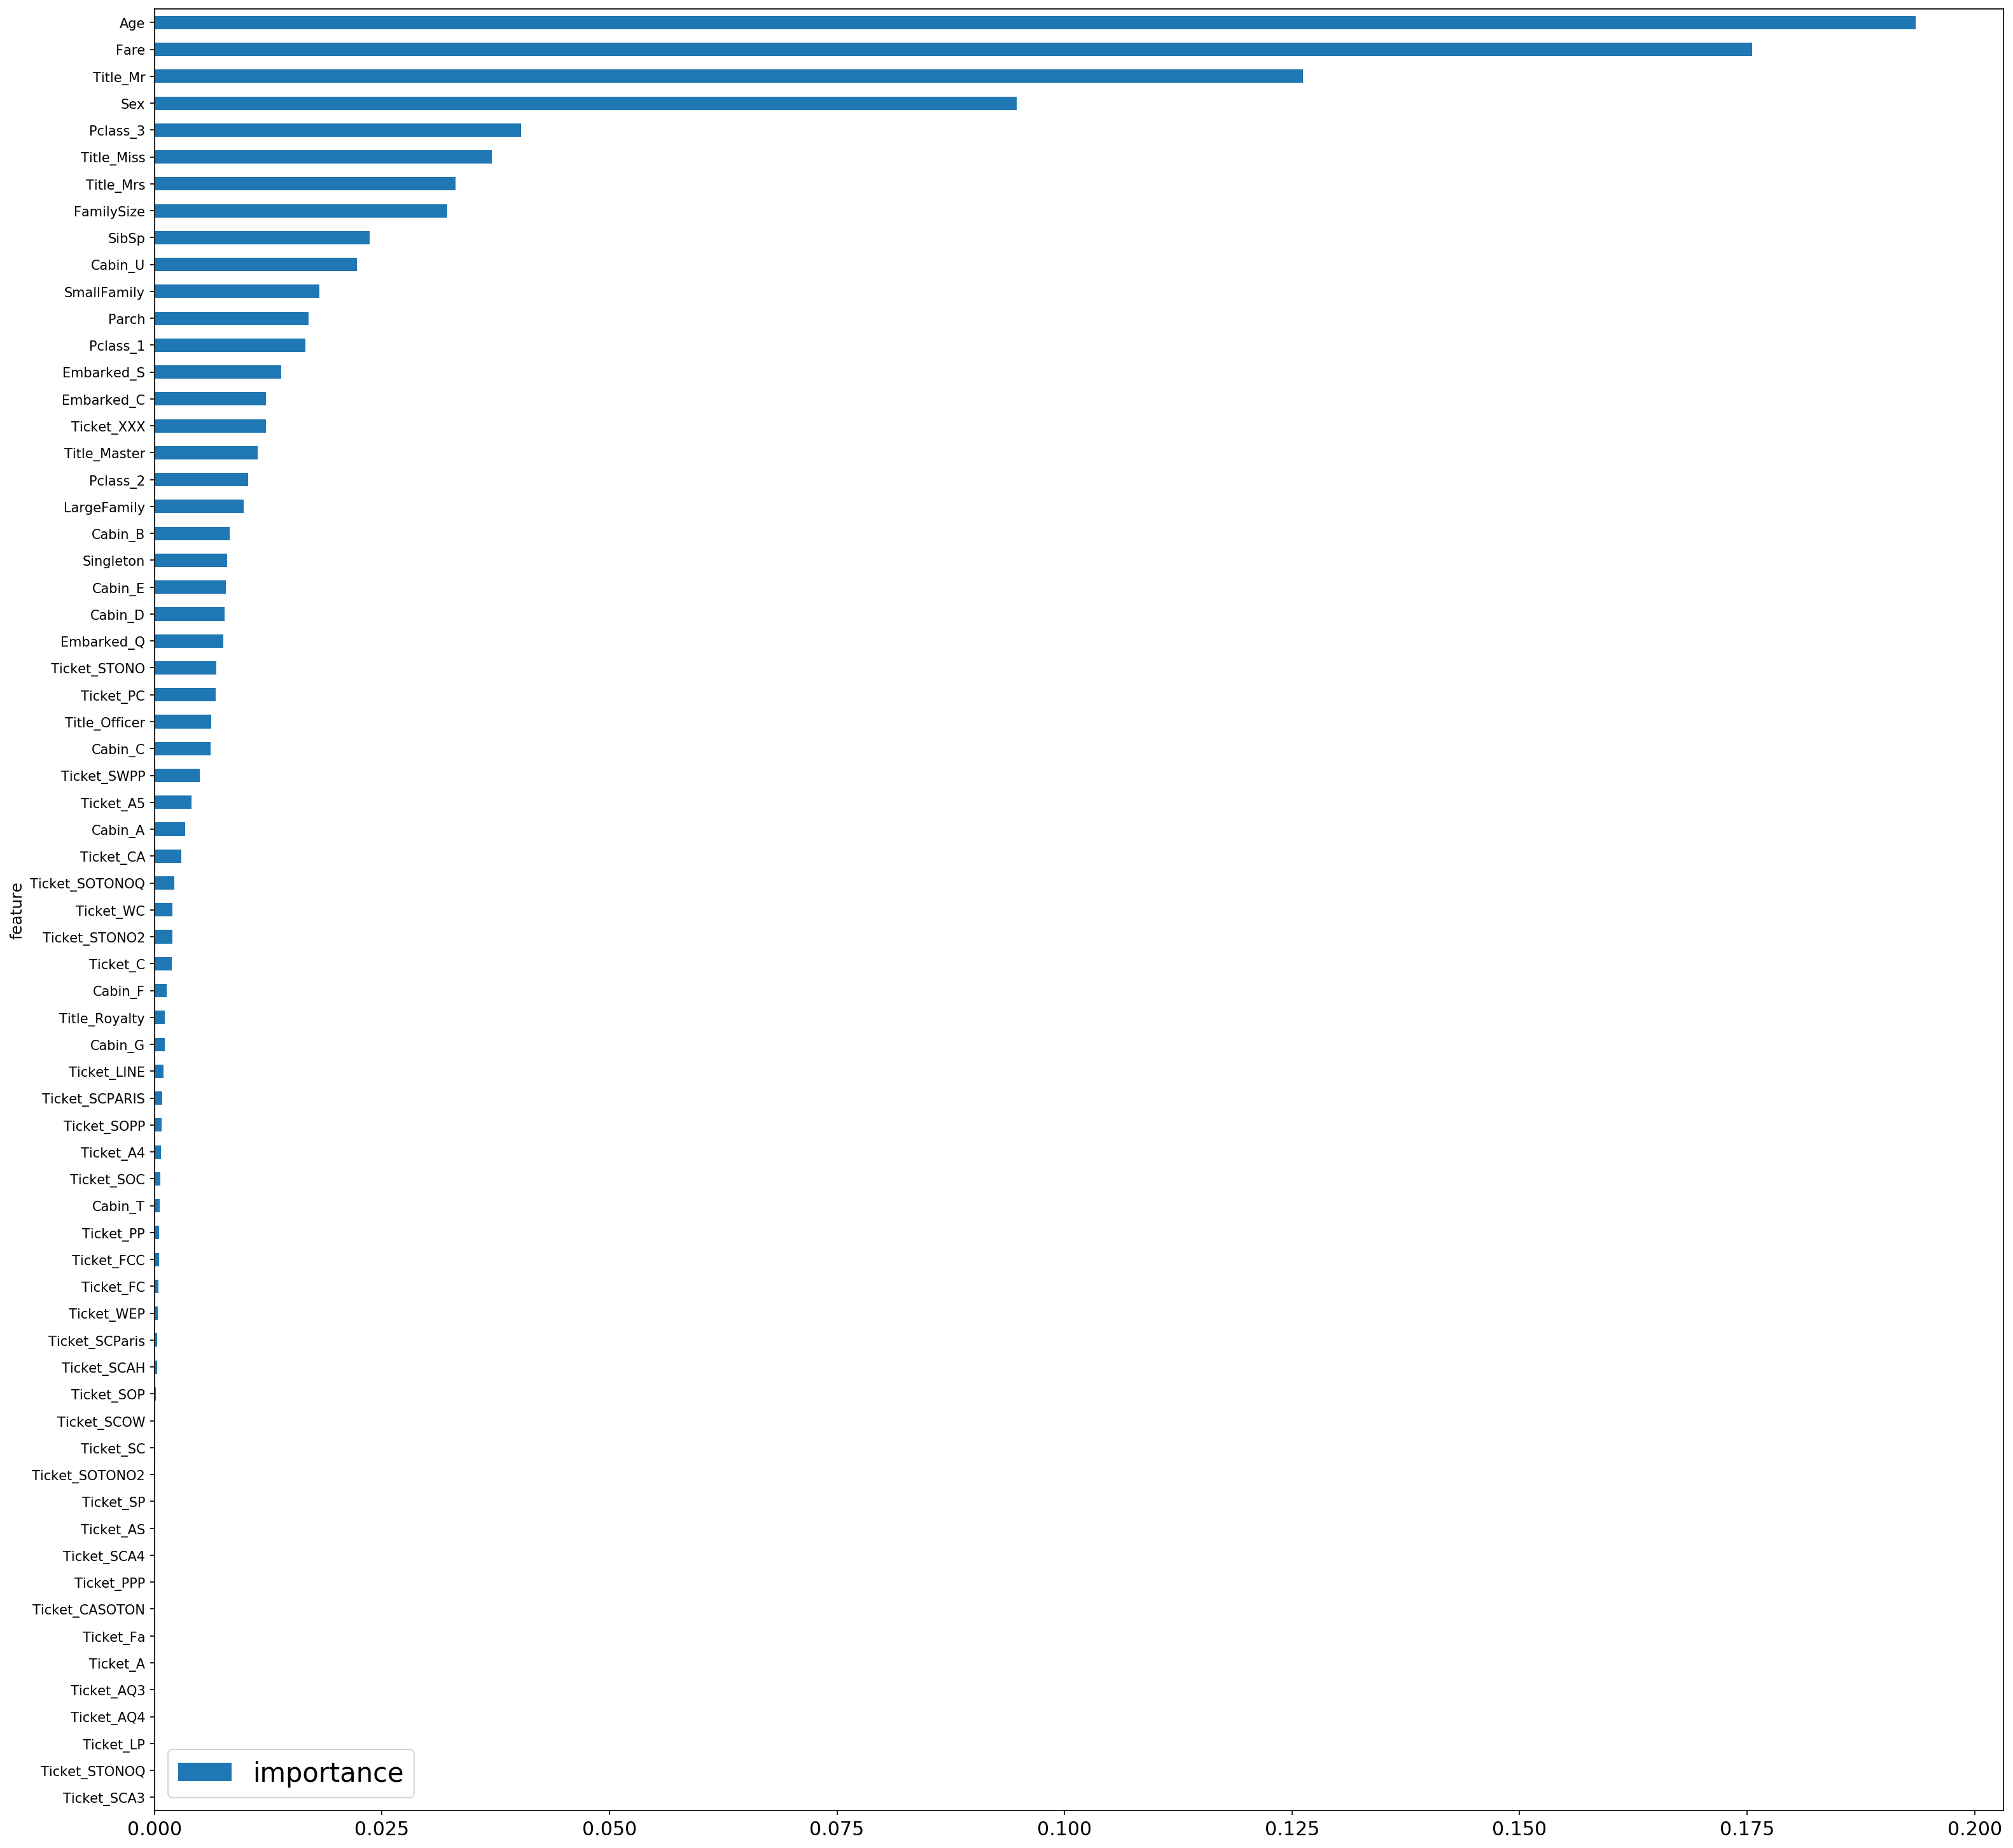

In [379]:
features.plot(kind='barh', figsize=(25, 25))

![energy](https://github.com/HisakaKoji/How-to-score-0.8134-in-Titanic-Kaggle-Challenge/blob/master/images/article_1/8.png?raw=1)

As you may notice, there is a great importance linked to Title_Mr, Age, Fare, and Sex. 

There is also an important correlation with the Passenger_Id.

Let's now transform our train set and test set in a more compact datasets. 

In [380]:
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train)
print (train_reduced.shape)

(891, 13)


In [381]:
test_reduced = model.transform(test)
print (test_reduced.shape)

(418, 13)


Yay! Now we're down to a lot less features.

We'll see if we'll use the reduced or the full version of the train set.

### Let's try different base models

In [0]:
logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models = [logreg, logreg_cv, rf, gboost]

In [383]:
for model in models:
    print ('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_reduced, y=targets, scoring='accuracy')
    print ('CV score = {0}'.format(score))
    print ('****')

Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegression'>
CV score = 0.8125832554019151
****
Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
CV score = 0.8215658842316813
****
Cross-validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score = 0.811497393242823
****
Cross-validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
CV score = 0.8249176976842577
****


### Hyperparameters tuning

As mentioned in the beginning of the Modeling part, we will be using a Random Forest model. It may not be the best model for this task but we'll show how to tune. This work can be applied to different models.

Random Forest are quite handy. They do however come with some parameters to tweak in order to get an optimal model for the prediction task.

To learn more about Random Forests, you can refer to this <a href="https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/">link </a>: 

Additionally, we'll use the full train set.

In [0]:
# turn run_gs to True if you want to run the gridsearch again.
run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)

Now that the model is built by scanning several combinations of the hyperparameters, we can generate an output file to submit on Kaggle.

In [0]:
output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('./data/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('./predictions/gridsearch_rf.csv', index=False)

### [BONUS]  Blending different models

I haven't personally uploaded a submission based on model blending but here's how you could do it

In [0]:
trained_models = []
for model in models:
    model.fit(train, targets)
    trained_models.append(model)

predictions = []
for model in trained_models:
    predictions.append(model.predict_proba(test)[:, 1])

predictions_df = pd.DataFrame(predictions).T
predictions_df['out'] = predictions_df.mean(axis=1)
predictions_df['PassengerId'] = aux['PassengerId']
predictions_df['out'] = predictions_df['out'].map(lambda s: 1 if s >= 0.5 else 0)

predictions_df = predictions_df[['PassengerId', 'out']]
predictions_df.columns = ['PassengerId', 'Survived']

In [0]:
predictions_df.to_csv('./predictions/blending_base_models.csv', index=False)

To have a good blending submission, the base models should be different and their correlations uncorrelated.

# IV - Conclusion

In this article, we explored an interesting dataset brought to us by <a href="http://kaggle.com">Kaggle</a>.

We went through the basic bricks of a data science pipeline:

- Data exploration and visualization: an initial step to formulate hypotheses
- Data cleaning 
- Feature engineering 
- Feature selection
- Hyperparameters tuning
- Submission
- Blending

This post can be downloaded as a notebook if you ever want to test and play with it : <a href="https://github.com/ahmedbesbes/post1/blob/master/titanic-article.ipynb"> my github repo </a>

Lots of articles have been written about this challenge, so obviously there is a room for improvement.

Here is what I suggest for next steps:

- Dig more in the data and eventually build new features.
- Try different models : logistic regressions, Gradient Boosted trees, XGboost, ...
- Try ensemble learning techniques (stacking)
- Run auto-ML frameworks

I would be more than happy if you could find out a way to improve my solution. This could make me update the article and definitely give you credit for that. So feel free to post a comment.